# Beginner's Guide to Decision Trees & Random Forests


### What is a Decision Tree?

Imagine you are not feeling well and you go to a doctor for a flu diagnosis: a simple yes or no answer from a doctor will help you decide what actions to take next. The doctor tells you she can make an educated guess based on a series of questions; for example she check your temperature and ask you if about other symptoms. Since she has seen many flu patients over the years, she will probably ask you what she believes are the most relevant questions first before moving on, in order to maximize the **information gain** of each question.

In this example, the doctor's questionare is built like a single **decision tree**, where a diagnosis is acheived by sorting information (fever or no fever, chills or no chills, etc...) and assigning probability to the final prediction (having the flu or not) based on these parameters. 

Sometimes, you may be skeptical of the doctor's prognosis (or all the time, if you are a true hypochondriac!) and may wish to speak to another doctor (or several). Then you can take the majority opinion from the collection of diagnoses (**an ensemble method**). 

Generally speaking, a majority opinion is a safer bet than a single person's opinion. The same is true with decision trees. A collection of uncorrelated models working towards a common goal will outperform a single model with the same intent. 

Let's see it in action!

You can find the csv dataset [here](https://www.lendingclub.com/auth/login?login_url=%2Fstatistics%2Fadditional-statistics%3F) or use your own! For our purposes, the dataset I am using has been cleaned and null values have been imputated/removed.

### Premilinary Data Analysis
Let's import the tools we need to check out our data.

In [1]:
# Import analytical libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Import the dataset from your drive

loans = pd.read_csv('loan_data.csv')

loans.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [3]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
credit.policy        9578 non-null int64
purpose              9578 non-null object
int.rate             9578 non-null float64
installment          9578 non-null float64
log.annual.inc       9578 non-null float64
dti                  9578 non-null float64
fico                 9578 non-null int64
days.with.cr.line    9578 non-null float64
revol.bal            9578 non-null int64
revol.util           9578 non-null float64
inq.last.6mths       9578 non-null int64
delinq.2yrs          9578 non-null int64
pub.rec              9578 non-null int64
not.fully.paid       9578 non-null int64
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [4]:
loans.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


I notice that the 25-75 percentile of dependent variable column "not.fully.paid" is the value 0.0 , and the mean is 0.16. This leads suspect we may have some class imbalance. Let's keep that in mind as we continue.

Let's use visualization to explore further.

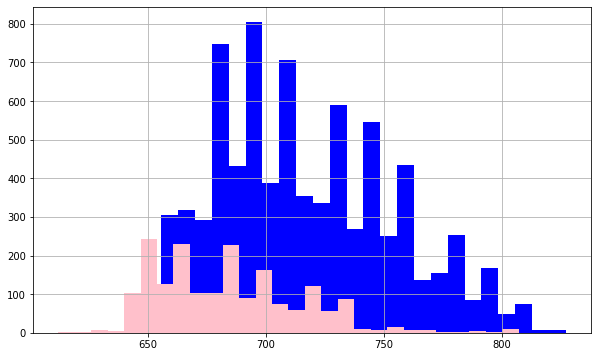

In [11]:
# Visualize fico distributions for credit.policy == 1 and credit.policy==0

fig = plt.figure(figsize=(10,6))
loans[loans['credit.policy']==1]['fico'].hist(bins=28,color='blue')
loans[loans['credit.policy']==0]['fico'].hist(bins=28, color='pink')

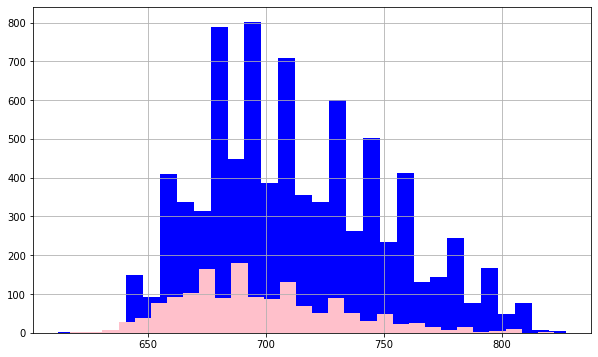

In [16]:
# Let's do the same for fico distributions and our target variable

fig = plt.figure(figsize=(10,6))

loans[loans['not.fully.paid']==0]['fico'].hist(bins=30, color='blue')
loans[loans['not.fully.paid']==1]['fico'].hist(bins=30, color='pink')

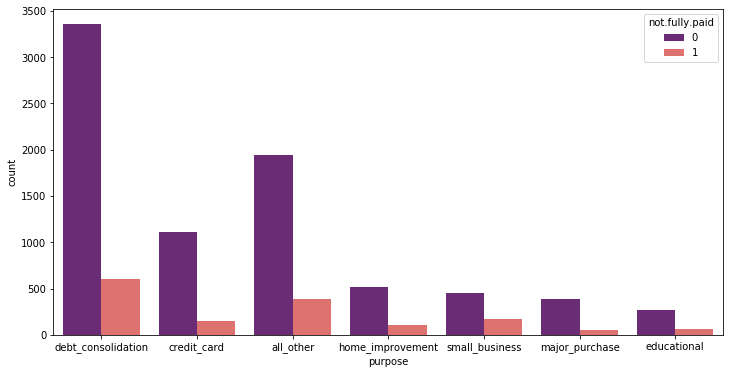

In [20]:
# Use seaborn to display a countplot for our target variable

plt.figure(figsize=(12,6))

sns.countplot(x='purpose', data=loans
              , hue='not.fully.paid'
              #, palette = 'magma'
             )

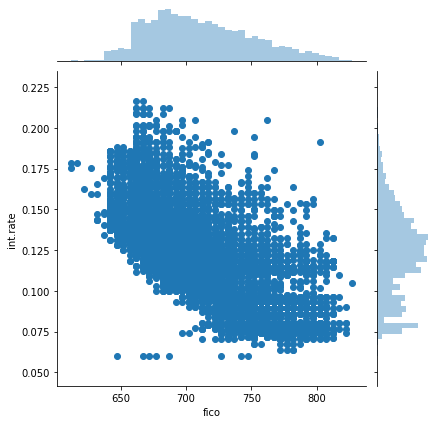

In [21]:
# Let's check trends between interest rate and fico scores. Is this a positive correlation or 
# a negative correlation? 

sns.jointplot(y = 'int.rate', x='fico', data=loans)

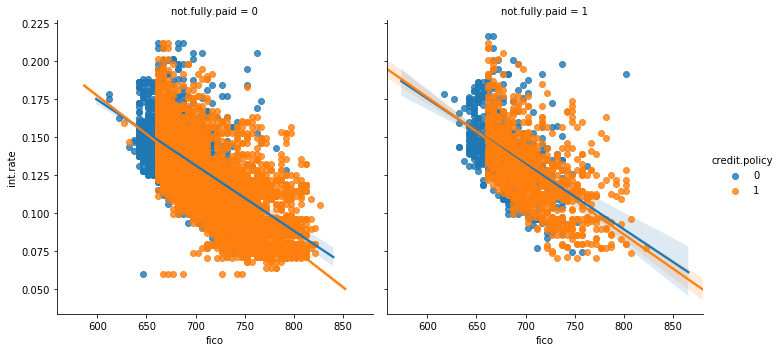

In [22]:
# We see a negative correlation between interest rates and fico scores, i.e. when interest rates go down,
# fico scores go up. Let's confirm this with an lmplot to check the regression line

sns.lmplot(y = 'int.rate', x='fico', data=loans
           , hue='credit.policy', col='not.fully.paid' # Split the graphs with colors & columns for readability
          )

### Data Prep

Now that we've done some initial exploration and verified nothing looks too out of the ordinary, let's continue by prepping our data for ML use.

In [23]:
# Remind yourself how the schema of our dataframe looks

loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
credit.policy        9578 non-null int64
purpose              9578 non-null object
int.rate             9578 non-null float64
installment          9578 non-null float64
log.annual.inc       9578 non-null float64
dti                  9578 non-null float64
fico                 9578 non-null int64
days.with.cr.line    9578 non-null float64
revol.bal            9578 non-null int64
revol.util           9578 non-null float64
inq.last.6mths       9578 non-null int64
delinq.2yrs          9578 non-null int64
pub.rec              9578 non-null int64
not.fully.paid       9578 non-null int64
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


The purpose column is a categorical variable that would need to be one-hot encoded. If we have too many unique values, one hot encoding can be quite messy. There are steps we can take to minimize this issue, but let's just get a baseline of how many values we're dealing with.

In [24]:
# Count the unique values of the categorical variable column

loans['purpose'].value_counts()

debt_consolidation    3957
all_other             2331
credit_card           1262
home_improvement       629
small_business         619
major_purchase         437
educational            343
Name: purpose, dtype: int64

In [26]:
# Since there are relatively few values, we can just move forward with one-hot-encoding this column.

# Make a list of columns to one-hot-encode
cat_cols = ['purpose']

# Create a final_data dataframe with dummy variables for categorical features
final_data = pd.get_dummies(loans,columns=cat_cols,drop_first=True)

# Confirm it looks as expected
final_data.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,1,0,0,0,0,0


Nice! Finally, we must split the data into training and testing data.

In [27]:
# Import train test split
from sklearn.model_selection import train_test_split

# Split the data

X_train, X_test , y_train, y_test = train_test_split(final_data.drop('not.fully.paid', axis=1), 
                                                     final_data['not.fully.paid'],
                                                     test_size=0.3, random_state=101)

### Single Decision Tree

Let's check out the results of a single decision tree, so we can compare them to our random forest later.

In [29]:
# Import the decision tree

from sklearn.tree import DecisionTreeClassifier

# Initiate the variable

dtree = DecisionTreeClassifier()

# Fit the model
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [30]:
# Create a variable with the tree predicitions

tree_pred = dtree.predict(X_test)

In [32]:
# Import evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(tree_pred, y_test))
print('\n')
print(confusion_matrix(tree_pred, y_test))


              precision    recall  f1-score   support

           0       0.82      0.85      0.84      2341
           1       0.23      0.19      0.21       533

    accuracy                           0.73      2874
   macro avg       0.53      0.52      0.52      2874
weighted avg       0.71      0.73      0.72      2874



[[2001  340]
 [ 430  103]]


A single decision tree was able to predict with an accuracy of 73%, which is not bad at all for the few lines of code we wrote. The '1' value seems to have exceptionally poor precision and recall simply because it was so imbalanced in our initial dataset. We will discuss more advanced methods of class balancing (such as oversampling with SMOTE) in the future, but for now just take note of what happens when we start with a low sample of one value over another.


### Random Forest Ensemble

In [33]:
# Repeat ML steps for ensemble method , don't worry if you get a warning

from sklearn.ensemble import RandomForestClassifier

rand = RandomForestClassifier()

rand.fit(X_train,y_train)

/home/hanna/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [34]:
# Make predictions & evaluate the results (feel free to copy/paste if you change accordingly)

rand_pred = rand.predict(X_test)

print(classification_report(rand_pred, y_test))
print('\n')
print(confusion_matrix(rand_pred, y_test))


              precision    recall  f1-score   support

           0       0.98      0.85      0.91      2815
           1       0.05      0.34      0.08        59

    accuracy                           0.84      2874
   macro avg       0.51      0.59      0.50      2874
weighted avg       0.96      0.84      0.89      2874



[[2392  423]
 [  39   20]]


Our accuracy jumped from 73% to 84% with **no additional lines of code** !! Woohoo!!

Congrats on finishing your first random forest, stay tuned for more advanced ML models.